In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import RFE
import numpy as np
import utils

In [3]:
data = pd.read_csv('Data/Post_Visualization_Data_10-12.csv')

These two columns are the indeces from the dataframe and were put into the csv file, but they aren't necessary so I'm deleting them.

In [7]:
del data['Unnamed: 0']
del data['Unnamed: 0.1']

I am creating the training data set here. I am holding out only 5% of the data for testing. I think that 5% will be enough considering the cleaned data contains 696,781 observations. This will allow for 34,839 observations to be used as test data, which seems like plenty.

In [8]:
X_train, X_test = train_test_split(data, test_size = 0.05,random_state=10082020)

Assigning the target variable to y, and the rest of the variables to X.

In [9]:
p_variables = list(X_train.columns)
p_variables.remove('Died')
X = X_train[p_variables]
y = X_train['Died']

# Logistic Regression

## Performing Forward Stepwise Selection of Variables

In [12]:
log_model = LogisticRegression(penalty = 'none', max_iter= 10000)
features, factors = utils.forwardSelection(X,y,log_model,'Deviance')

The cell above took multiple hours to run, so below I am writing the output to a csv file so I don't have to run the above cell again.

In [13]:
output_lines = []
for feature in features:
    line = "Features ["
    for item in feature:
        line += str(item)
        line += ","
    line += "]"
    output_lines.append(line)

output_df = pd.DataFrame({'features':output_lines[1:],'factors':factors})
output_df.to_csv('ForwardSelectionResults10-12.csv')

Below is a plot of the Deviance (comparable to MSE or R-squared for Regression problems)

Text(0, 0.5, 'Deviance')

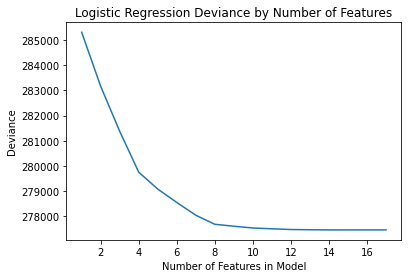

In [14]:
fwdselection = pd.read_csv('ForwardSelectionResults10-12.csv')
#in order to be maximizing this factor in the forward stepwise selection function, I had to make this negative. I am turning it positive again
fwd_deviance = -1*fwdselection['factors']
num_fwd_features = fwdselection['features']

plt.plot(np.arange(1,len(num_fwd_features)),fwd_deviance[1:])
plt.title("Logistic Regression Deviance by Number of Features")
plt.xlabel("Number of Features in Model")
plt.ylabel("Deviance")
#plt.savefig("Forward Selection Deviance.png")

This shows me that after 10 factors are included, the models fit doesn't really get any better. The model with 10 features is shown below.

In [15]:
num_fwd_features[9]

'Features [Pneumonia,Age,Kidney Failure,Sex_1,Diabetes,Obesity,Residence_3,Other Diseases,Hypertension,Immunosuppression,]'

Below shows performing 10-fold cross validation for each model and the resulting estimated test accuracy for each model. This agrees with the deviance plot above, showing the accuracy does not increase after the model has 10 features.

In [17]:
all_metrics = utils.performValidations(X,y,features[1:],10,log_model)

In [103]:
fwd_precision, fwd_recall, fwd_acc = utils.getMetricSummaries(all_metrics)

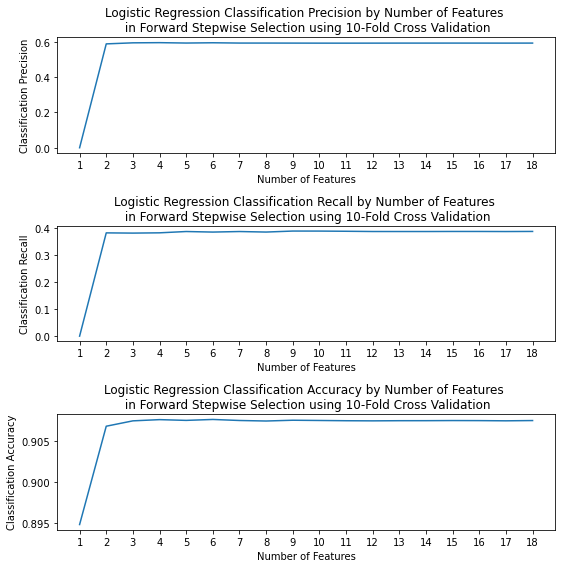

In [30]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(8, 8)
ax[0].plot(np.arange(1,19,1),fwd_precision)
ax[0].set_title("Logistic Regression Classification Precision by Number of Features \n in Forward Stepwise Selection using 10-Fold Cross Validation")
ax[0].set_xlabel("Number of Features")
ax[0].set_ylabel("Classification Precision")
ax[0].set_xticks(np.arange(1,19,1))
ax[1].plot(np.arange(1,19,1),fwd_recall)
ax[1].set_title("Logistic Regression Classification Recall by Number of Features \n in Forward Stepwise Selection using 10-Fold Cross Validation")
ax[1].set_xlabel("Number of Features")
ax[1].set_ylabel("Classification Recall")
ax[1].set_xticks(np.arange(1,19,1))
ax[2].plot(np.arange(1,19,1),fwd_acc)
ax[2].set_title("Logistic Regression Classification Accuracy by Number of Features \n in Forward Stepwise Selection using 10-Fold Cross Validation")
ax[2].set_xlabel("Number of Features")
ax[2].set_ylabel("Classification Accuracy")
ax[2].set_xticks(np.arange(1,19,1))
fig.tight_layout()
#plt.savefig('Forward Selection Metrics.png')

Despite the Deviance plot showing 10 factors are needed, the test metrics found using cross validation suggest that the precision, and recall are nearly maximized while only using 2 features and the accuracy is nearly maximized by using 4 features. The model using 4 features is shown below.

In [22]:
log_model = LogisticRegression(penalty = 'none', max_iter= 10000)
log_model.fit(X[features[4]],y)

LogisticRegression(max_iter=10000, penalty='none')

In [23]:
print(features[4])
print(log_model.coef_)

['Pneumonia', 'Age', 'Kidney Failure', 'Sex_1']
[[ 2.49177656  0.06136389  1.13189119 -0.4270971 ]]


The estimated test accuracy seems to flat line after the model has 4 features. Therefore, the logistic model I will choose from forward stepwise selection contains the following features:

In [24]:
print("Model has accuracy of "+str(fwd_acc[3]))
print("Model has precision of "+str(fwd_precision[3]))
print("Model has recall of "+str(fwd_recall[3]))

Model has accuracy of 0.907630740504063
Model has precision of 0.5948854483622695
Model has recall of 0.3818886894075404


## Performing Backward Stepwise Selection of Variables

The below cell performs the backward selection, but only one step at a time instead of doing all the steps in one line of code. This cell captures the models at each step.

In [90]:
log_model = LogisticRegression(penalty = 'none', max_iter= 10000)
variables = list(X.columns)
v_len = len(variables)
models = [[]]
for i in range(v_len):
    selector2 = RFE(log_model,n_features_to_select=v_len-i,step=1)
    selector2 = selector2.fit(X[variables],y)
    variables = list(pd.Series(variables)[selector2.support_])
    models.append(variables)

The cell below uses the models created along each step of backward selection and does 10-Fold cross validation and records the mean accuracy for each model over the 10-folds.

In [91]:
#First I need to reverse the order of the models so that when graphing later on, the number of features is ascending rather
#than descending, and then do the cross validations
bwd_models = list(models[1:])
bwd_models.reverse()
log_model = LogisticRegression(penalty = 'none', max_iter= 10000)
back_metrics = utils.performValidations(X,y,bwd_models,10,log_model)

In [92]:
#getting the metric summaries for each models cross validation
bwd_precision, bwd_recall, bwd_acc = utils.getMetricSummaries(back_metrics)

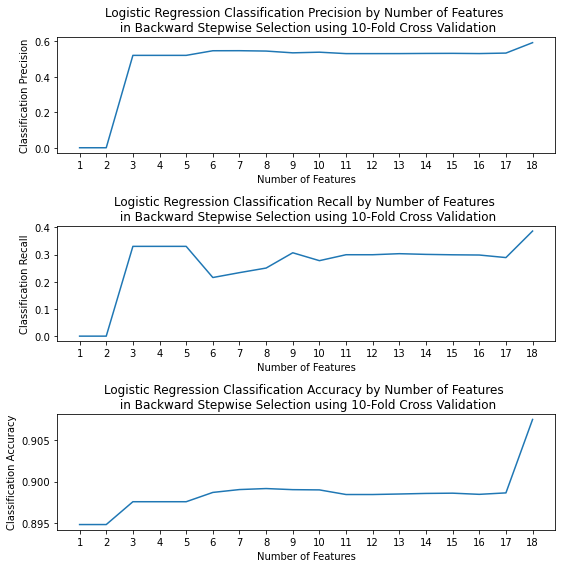

In [93]:
#plotting the metrics
fig, ax = plt.subplots(3,1)
fig.set_size_inches(8, 8)
ax[0].plot(np.arange(1,19,1),bwd_precision)
ax[0].set_title("Logistic Regression Classification Precision by Number of Features \n in Backward Stepwise Selection using 10-Fold Cross Validation")
ax[0].set_xlabel("Number of Features")
ax[0].set_ylabel("Classification Precision")
ax[0].set_xticks(np.arange(1,19,1))
ax[1].plot(np.arange(1,19,1),bwd_recall)
ax[1].set_title("Logistic Regression Classification Recall by Number of Features \n in Backward Stepwise Selection using 10-Fold Cross Validation")
ax[1].set_xlabel("Number of Features")
ax[1].set_ylabel("Classification Recall")
ax[1].set_xticks(np.arange(1,19,1))
ax[2].plot(np.arange(1,19,1),bwd_acc)
ax[2].set_title("Logistic Regression Classification Accuracy by Number of Features \n in Backward Stepwise Selection using 10-Fold Cross Validation")
ax[2].set_xlabel("Number of Features")
ax[2].set_ylabel("Classification Accuracy")
ax[2].set_xticks(np.arange(1,19,1))
fig.tight_layout()
plt.savefig('Backward Selection Metrics.png')

These graphs look a little strange when dropping from 18 to 17 features, but under close inspection, it is due to the removal of the Age feature, whic was actually found quite significant in the forward selection model. I am choosing the model with only 3 features because here the recall is highest (besides full model) and the precision and accuracy are not much lower than in the slightly more complex models.

In [85]:
print("Precision is "+str(bwd_precision[2]))
print("Recall is "+str(bwd_recall[2]))
print("Accuracy is "+str(bwd_acc[2]))

Precision is 0.5206155238741796
Recall is 0.33042728904847396
Accuracy is 0.8975694208396217


In [87]:
#these are the features used in the 3 feature backward selected model
bwd_models[2]

['Pneumonia', 'Pregnant', 'Hypertension']

In [88]:
#fitting the model of with 
log_model = LogisticRegression(penalty = 'none', max_iter= 10000)
log_model.fit(X[bwd_models[2]],y)
log_model.coef_

array([[ 2.89646745, -1.58728143,  0.99196177]])

## Performing L2 Regularization

In [46]:
#first need to standardize the age feature
age_normal = X['Age'].copy()
age_standardized = age_normal/age_normal.std()
X['Age'] = age_standardized
#I want to keep track of the coefficients and the return metrics
coefficients = []
l2_metrics = []
#I want to loop through a range of values with a broad step of 2, and if there appears to be a place where I need
#a higher granularity I will approach only a small section with the small granularity instead of the whole region
for c in range(-11,11,2):
    print(c)
    log_l2_model = LogisticRegression(penalty = 'l2', max_iter= 10000,C=10**c)
    l2_metric = utils.performValidations(X,y,[list(X.columns)],10,log_l2_model)
    l2_metrics.append(l2_metric[0])
    log_l2_model.fit(X,y)
    coefficients.append(log_l2_model.coef_)
    
#set age back to normal
X['Age'] = age_normal

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


-11
-9
-7
-5
-3
-1
1
3
5
7
9


C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
#these are the specific coefficients I want to show in a plot and explore as a function of C
pneumonia_coefs = []
sex_1_coefs = []
sex_2_coefs = []
residence_1_coefs = []
residence_3_coefs = []
cardio_coefs = []
for item in coefficients:
    pneumonia_coefs.append(item[0][0])
    sex_1_coefs.append(item[0][13])
    sex_2_coefs.append(item[0][14])
    residence_1_coefs.append(item[0][15])
    residence_3_coefs.append(item[0][17])
    cardio_coefs.append(item[0][9])

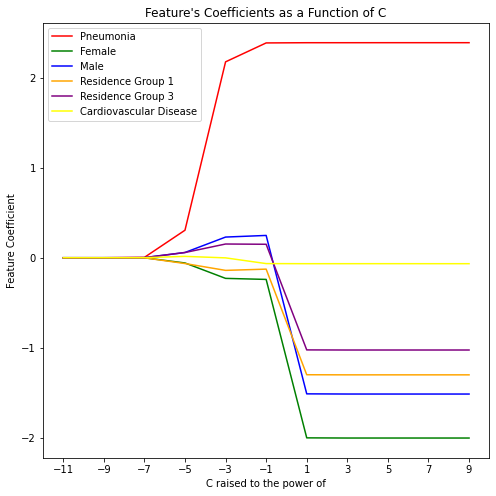

In [48]:
fig,ax=plt.subplots(1)
fig.set_size_inches(8, 8)
ax.plot(range(-11,11,2),pneumonia_coefs,color='red')
ax.plot(range(-11,11,2),sex_1_coefs,color='green')
ax.plot(range(-11,11,2),sex_2_coefs,color='blue')
ax.plot(range(-11,11,2),residence_1_coefs,color='orange')
ax.plot(range(-11,11,2),residence_3_coefs,color='purple')
ax.plot(range(-11,11,2),cardio_coefs,color='yellow')
ax.set_xlabel("C raised to the power of")
ax.set_ylabel("Feature Coefficient")
ax.set_title("Feature's Coefficients as a Function of C")
ax.legend(['Pneumonia','Female','Male','Residence Group 1','Residence Group 3','Cardiovascular Disease'])
ax.set_xticks(range(-11,11,2))

#fig.savefig('Regularization Coefficients.png')

In [49]:
#getting the summary metrics
l2_precision, l2_recall, l2_acc = utils.getMetricSummaries(l2_metrics)

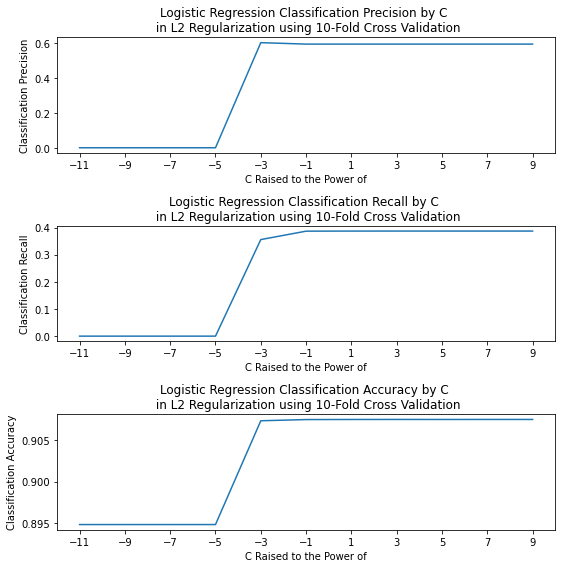

In [50]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(8, 8)
ax[0].plot(np.arange(-11,11,2),l2_precision)
ax[0].set_title("Logistic Regression Classification Precision by C \n in L2 Regularization using 10-Fold Cross Validation")
ax[0].set_xlabel("C Raised to the Power of")
ax[0].set_ylabel("Classification Precision")
ax[0].set_xticks(np.arange(-11,11,2))
ax[1].plot(np.arange(-11,11,2),l2_recall)
ax[1].set_title("Logistic Regression Classification Recall by C \n in L2 Regularization using 10-Fold Cross Validation")
ax[1].set_xlabel("C Raised to the Power of")
ax[1].set_ylabel("Classification Recall")
ax[1].set_xticks(np.arange(-11,11,2))
ax[2].plot(np.arange(-11,11,2),l2_acc)
ax[2].set_title("Logistic Regression Classification Accuracy by C \n in L2 Regularization using 10-Fold Cross Validation")
ax[2].set_xlabel("C Raised to the Power of")
ax[2].set_ylabel("Classification Accuracy")
ax[2].set_xticks(np.arange(-11,11,2))
fig.tight_layout()
#plt.savefig('Regularization Metrics.png')

The recall and acurracy are maximized with C being 10 raised to -1 or more. However, the precision is maximized at C of 10 raised to -3. When looking at the coefficient plot a few cells above, having C equal to 10 raised to -3 seems like the best fitting model. The accuracy metrics are shown below as well as the coefficients.

In [56]:
print("L2 Precision is "+str(l2_precision[4]))
print("L2 Recall is "+str(l2_recall[4]))
print("L2 Accuracy is "+str(l2_acc[4]))
coef_df = pd.DataFrame({'Feature':list(X.columns),'Coefficients':list(coefficients[4][0])})
print(coef_df)

L2 Precision is 0.6007230026445399
L2 Recall is 0.3556193895870736
L2 Accuracy is 0.9073603236542229
                   Feature  Coefficients
0                Pneumonia      2.176058
1                      Age      0.941484
2                 Pregnant     -0.002618
3                 Diabetes      0.361560
4           COPD Diagnosis      0.108142
5                   Asthma     -0.043312
6        Immunosuppression      0.179212
7             Hypertension      0.237910
8           Other Diseases      0.346460
9   Cardiovascular Disease     -0.001604
10                 Obesity      0.250927
11          Kidney Failure      0.581737
12                  Smoker     -0.067741
13                   Sex_1     -0.229459
14                   Sex_2      0.229489
15             Residence_1     -0.140633
16             Residence_2     -0.011624
17             Residence_3      0.152288


# Building Decision Tree Models

I would like to loop through the different number of leaf nodes to see what the minimum complexity is to obtain maximum accuracy. I will use 10-fold cross validation to achieve this.

In [59]:
tree_metrics = []
for i in range(2,31):
    covid_tree = tree.DecisionTreeClassifier(max_leaf_nodes=i)
    tree_metric = utils.performValidations(X,y,[list(X.columns)],10,covid_tree)
    tree_metrics.append(tree_metric[0])

In [60]:
tree_precision, tree_recall, tree_acc = utils.getMetricSummaries(tree_metrics)

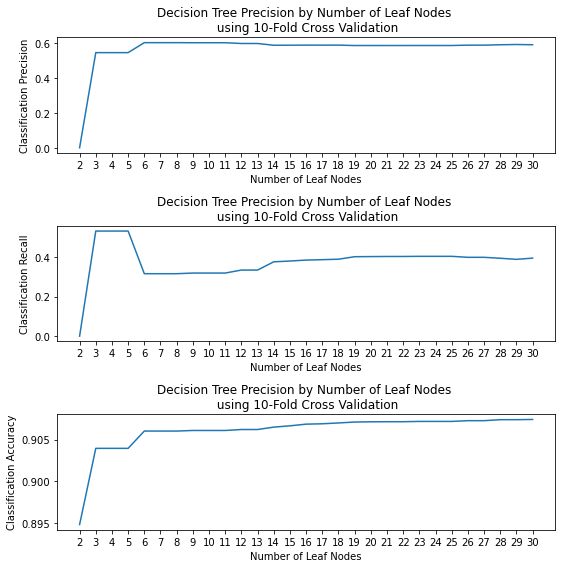

In [61]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(8, 8)
ax[0].plot(np.arange(2,31,1),tree_precision)
ax[0].set_title("Decision Tree Precision by Number of Leaf Nodes \n using 10-Fold Cross Validation")
ax[0].set_xlabel("Number of Leaf Nodes")
ax[0].set_ylabel("Classification Precision")
ax[0].set_xticks(np.arange(2,31,1))
ax[1].plot(np.arange(2,31,1),tree_recall)
ax[1].set_title("Decision Tree Precision by Number of Leaf Nodes \n using 10-Fold Cross Validation")
ax[1].set_xlabel("Number of Leaf Nodes")
ax[1].set_ylabel("Classification Recall")
ax[1].set_xticks(np.arange(2,31,1))
ax[2].plot(np.arange(2,31,1),tree_acc)
ax[2].set_title("Decision Tree Precision by Number of Leaf Nodes \n using 10-Fold Cross Validation")
ax[2].set_xlabel("Number of Leaf Nodes")
ax[2].set_ylabel("Classification Accuracy")
ax[2].set_xticks(np.arange(2,31,1))
fig.tight_layout()
#plt.savefig('Tree Leaf Metrics.png')

In [62]:
print("Three leaved tree precision is "+str(tree_precision[1]))
print("Three leaved tree recall is "+str(tree_recall[1]))
print("Three leaved tree accuracy is "+str(tree_acc[1]))

Three leaved tree precision is 0.5445509511871406
Three leaved tree recall is 0.5303554757630161
Three leaved tree accuracy is 0.9039446113777512


Below is the drawing of the three leaved tree.

[Text(334.8, 679.5, 'Pneumonia <= 0.5\ngini = 0.188\nsamples = 661941\nvalue = [592316, 69625]'),
 Text(167.4, 407.69999999999993, 'gini = 0.065\nsamples = 539983\nvalue = [521833, 18150]'),
 Text(502.20000000000005, 407.69999999999993, 'Age <= 54.5\ngini = 0.488\nsamples = 121958\nvalue = [70483, 51475]'),
 Text(334.8, 135.89999999999998, 'gini = 0.39\nsamples = 53274\nvalue = [39114, 14160]'),
 Text(669.6, 135.89999999999998, 'gini = 0.496\nsamples = 68684\nvalue = [31369, 37315]')]

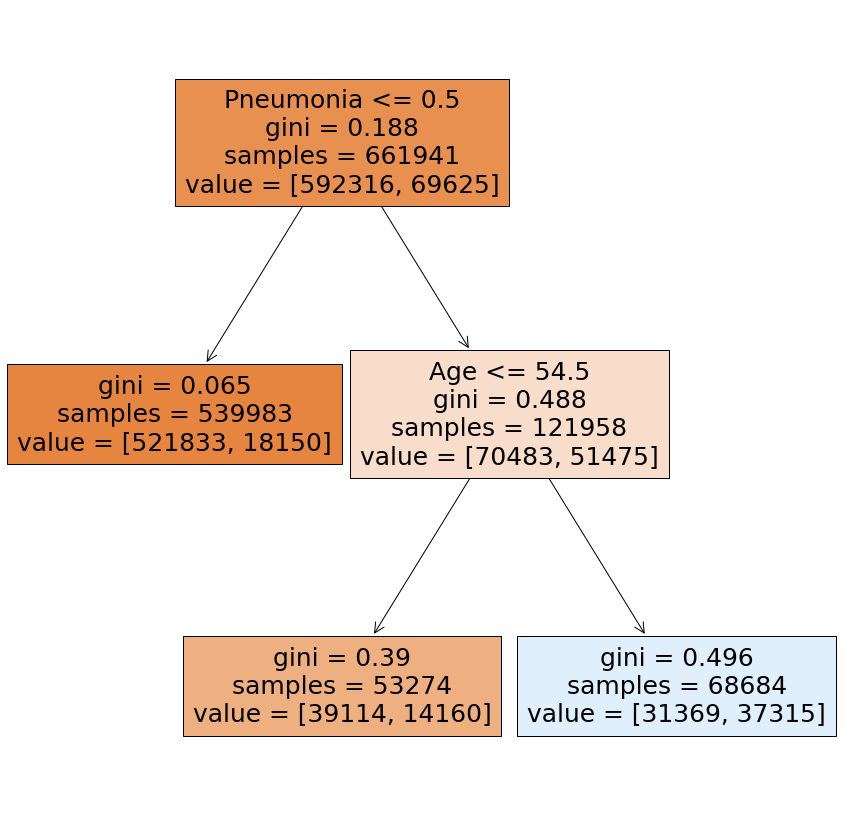

In [97]:
covid_tree_3 = tree.DecisionTreeClassifier(max_leaf_nodes=3)
covid_tree_3.fit(X,y)
fig = plt.figure(figsize= (15,15))
tree.plot_tree(covid_tree_3,
   feature_names= X.columns,
   filled=True)

## Pruning the Tree

In [64]:
#first using the cost_complexity_pruning_path from sklearn
covid_tree = tree.DecisionTreeClassifier(random_state=0)
pruning = covid_tree.cost_complexity_pruning_path(X,y)
ccp_alphas, impurities = pruning.ccp_alphas, pruning.impurities

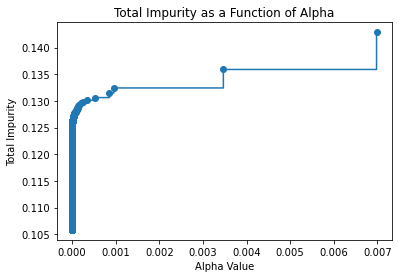

In [65]:
fig,ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("Alpha Value")
ax.set_ylabel("Total Impurity")
ax.set_title("Total Impurity as a Function of Alpha")
#fig.savefig('Tree_Pruning_Impurities')

In [66]:
#create a list of trees for each increment - these will be used for depth plots
covid_trees = []
for v in np.arange(0,.00725,.00025):
    covid_tree = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=max(0,v))
    covid_tree.fit(X, y)
    covid_trees.append(covid_tree)

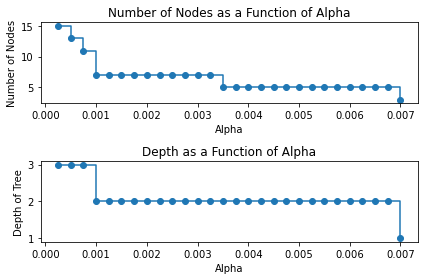

In [67]:
covid_trees = covid_trees
ccp_alphas = np.arange(0,.00725,.00025)

node_counts = [covid_tree.tree_.node_count for covid_tree in covid_trees]
depth = [covid_tree.tree_.max_depth for covid_tree in covid_trees]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas[1:], node_counts[1:], marker='o', drawstyle="steps-post")
ax[0].set_xlabel("Alpha")
ax[0].set_ylabel("Number of Nodes")
ax[0].set_title("Number of Nodes as a Function of Alpha")
ax[1].plot(ccp_alphas[1:], depth[1:], marker='o', drawstyle="steps-post")
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("Depth of Tree")
ax[1].set_title("Depth as a Function of Alpha")
fig.tight_layout()
#fig.savefig('Pruning_Tree_Sizes.png')

In [68]:
#now to go through each ccp_alpha (incremented by 0.001 this time) and then do k-fold cross validation in 
#order to get estimated test error rate and then select the ccp_alpha that yields the best test_accuracy
ccp_alphas_testing = np.arange(0,.008,.001)
prune_metrics = []
for v in ccp_alphas_testing:
    covid_tree = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=v)
    prune_metric = utils.performValidations(X,y,[list(X.columns)],10,covid_tree)
    prune_metrics.append(prune_metric[0])

In [69]:
prune_precision, prune_recall, prune_acc = utils.getMetricSummaries(prune_metrics)

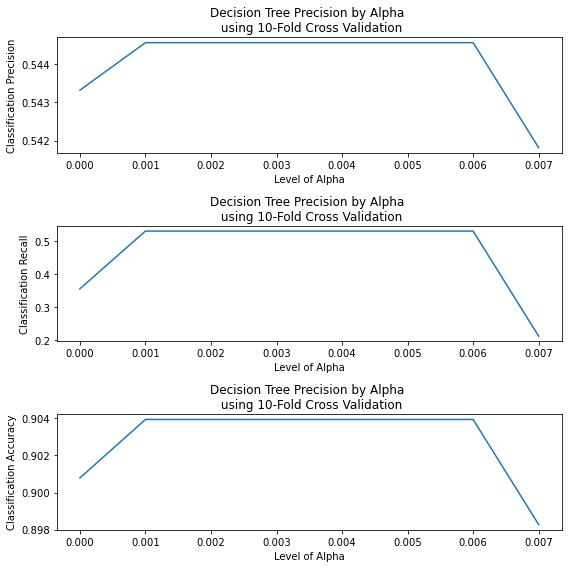

In [70]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(8, 8)
ax[0].plot(np.arange(0,0.008,.001),prune_precision)
ax[0].set_title("Decision Tree Precision by Alpha \n using 10-Fold Cross Validation")
ax[0].set_xlabel("Level of Alpha")
ax[0].set_ylabel("Classification Precision")
ax[1].plot(np.arange(0,.008,.001),prune_recall)
ax[1].set_title("Decision Tree Precision by Alpha \n using 10-Fold Cross Validation")
ax[1].set_xlabel("Level of Alpha")
ax[1].set_ylabel("Classification Recall")
ax[2].plot(np.arange(0,.008,.001),prune_acc)
ax[2].set_title("Decision Tree Precision by Alpha \n using 10-Fold Cross Validation")
ax[2].set_xlabel("Level of Alpha")
ax[2].set_ylabel("Classification Accuracy")
fig.tight_layout()
#plt.savefig('Tree Prune Metrics.png')

In [71]:
print("Pruned Tree Precision is "+str(prune_precision[1]))
print("Pruned Tree Recall is "+str(prune_recall[1]))
print("Pruned Tree Accuracy is "+str(prune_acc[1]))

Pruned Tree Precision is 0.5445509511871406
Pruned Tree Recall is 0.5303554757630161
Pruned Tree Accuracy is 0.9039446113777512


I have chosen an alpha value of 0.001 because this is where the complexity of the tree and the impurity starts to flatten out. Also, the estimated test metrics are maximized here. Below is the drawing of the tree chosen from cost complexity pruning.

[Text(418.5, 679.5, 'Pneumonia <= 0.5\ngini = 0.188\nsamples = 661941\nvalue = [592316, 69625]'),
 Text(209.25, 407.69999999999993, 'Age <= 63.5\ngini = 0.065\nsamples = 539983\nvalue = [521833, 18150]'),
 Text(104.625, 135.89999999999998, 'gini = 0.037\nsamples = 488382\nvalue = [479285, 9097]'),
 Text(313.875, 135.89999999999998, 'gini = 0.289\nsamples = 51601\nvalue = [42548, 9053]'),
 Text(627.75, 407.69999999999993, 'Age <= 54.5\ngini = 0.488\nsamples = 121958\nvalue = [70483, 51475]'),
 Text(523.125, 135.89999999999998, 'gini = 0.39\nsamples = 53274\nvalue = [39114, 14160]'),
 Text(732.375, 135.89999999999998, 'gini = 0.496\nsamples = 68684\nvalue = [31369, 37315]')]

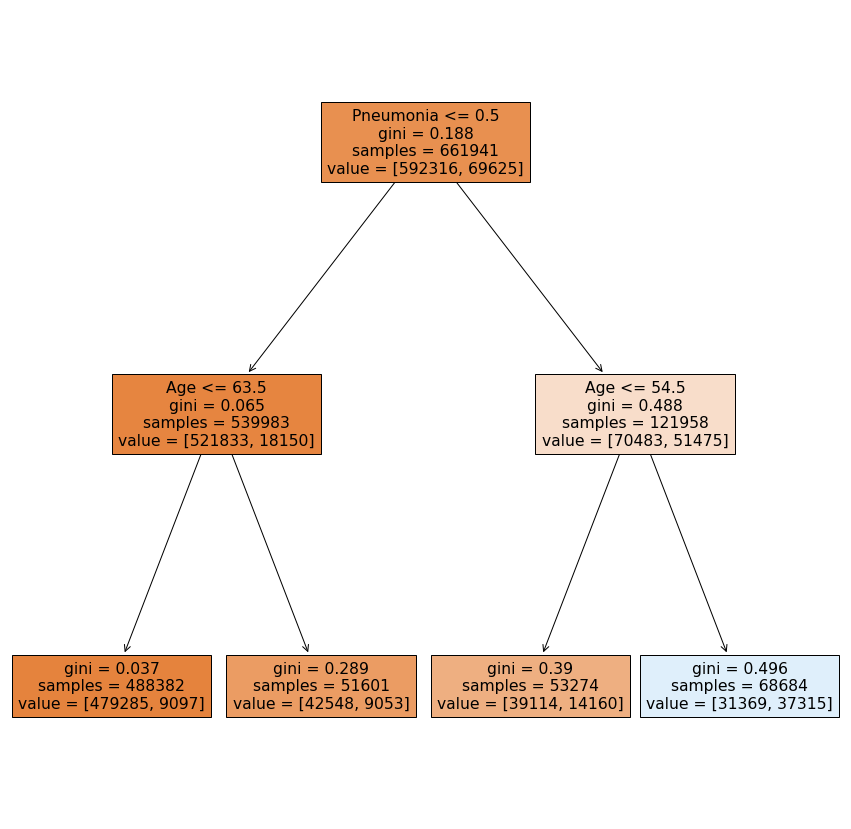

In [99]:
#showing the pruned tree of choice
covid_tree_pruned = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=0.001)
covid_tree_pruned.fit(X,y)
fig = plt.figure(figsize= (15,15))
tree.plot_tree(covid_tree_pruned,
   feature_names= X.columns,
   filled=True)

# Testing the chosen model of L2 Logistic Regression on the Test Data

In [73]:
#training the model with the full training data
log_l2_model = LogisticRegression(penalty = 'l2', max_iter= 10000,C=0.001)
log_l2_model.fit(X,y)

LogisticRegression(C=0.001, max_iter=10000)

In [76]:
#getting the testing data ready
X_testing = X_test[p_variables]
Y_testing = X_test['Died']

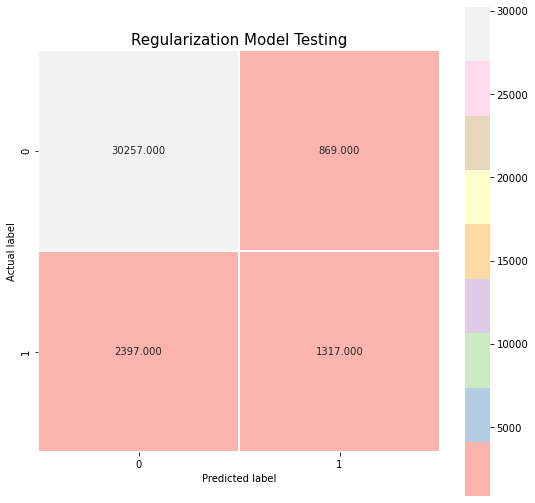

Accuracy = 0.9062571756601607
Precision = 0.6024702653247942
Recall = 0.3546042003231018


In [77]:
#creating predictions of the test data
predictions = log_l2_model.predict(X_testing)

#getting the test metrics
cm = metrics.confusion_matrix(Y_testing, predictions)

#deriving the accuracy, precision, and recall
l2_acc = (cm[0][0]+cm[1][1])/(sum(cm[0])+sum(cm[1]))
l2_prec = cm[1][1]/(cm[1][1]+cm[0][1])
l2_rec = cm[1][1]/(cm[1][0]+cm[1][1])
#plotting the metrics
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Pastel1');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Regularization Model Testing", size = 15);
plt.show()

print("Accuracy = " +str(l2_acc))
print("Precision = "+str(l2_prec))
print("Recall = "+str(l2_rec))

The test metrics are pretty similar to the estimated test metrics from using 10-fold cross validation in the training data.

# Testing the Chosen Model of Decision Tree with 3 Leaf Nodes on Test Data

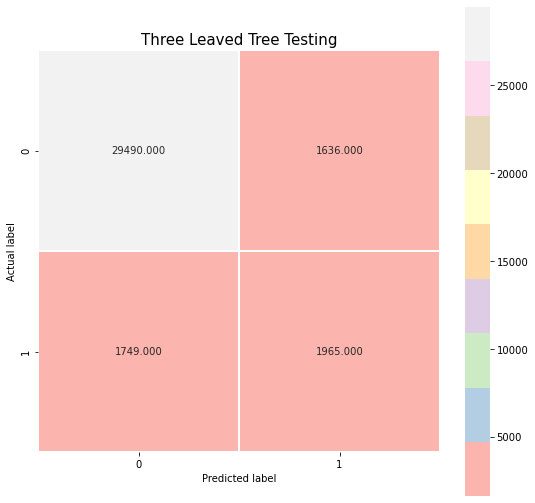

Accuracy = 0.902841561423651
Precision = 0.5456817550680366
Recall = 0.5290791599353797


In [82]:
#training the model
covid_tree_test = tree.DecisionTreeClassifier(max_leaf_nodes=3)
covid_tree_test.fit(X,y)

#making predictions
tree_predictions = covid_tree_test.predict(X_testing)

#creating metrics table
cm = metrics.confusion_matrix(Y_testing, tree_predictions)

#deriving the accuracy, precision, and recall
tree_acc = (cm[0][0]+cm[1][1])/(sum(cm[0])+sum(cm[1]))
tree_prec = cm[1][1]/(cm[1][1]+cm[0][1])
tree_rec = cm[1][1]/(cm[1][0]+cm[1][1])

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Pastel1');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Three Leaved Tree Testing", size = 15);
plt.show()

print("Accuracy = " +str(tree_acc))
print("Precision = "+str(tree_prec))
print("Recall = "+str(tree_rec))

The test metrics are pretty similar to the estimated test metrics from using 10-fold cross validation in the training data.